Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24       |
|    ep_rew_mean     | -45.2    |
| time/              |          |
|    fps             | 2538     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 24         |
|    ep_rew_mean          | -23.4      |
| time/                   |            |
|    fps                  | 1671       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03559818 |
|    clip_fraction        | 0.216      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.58

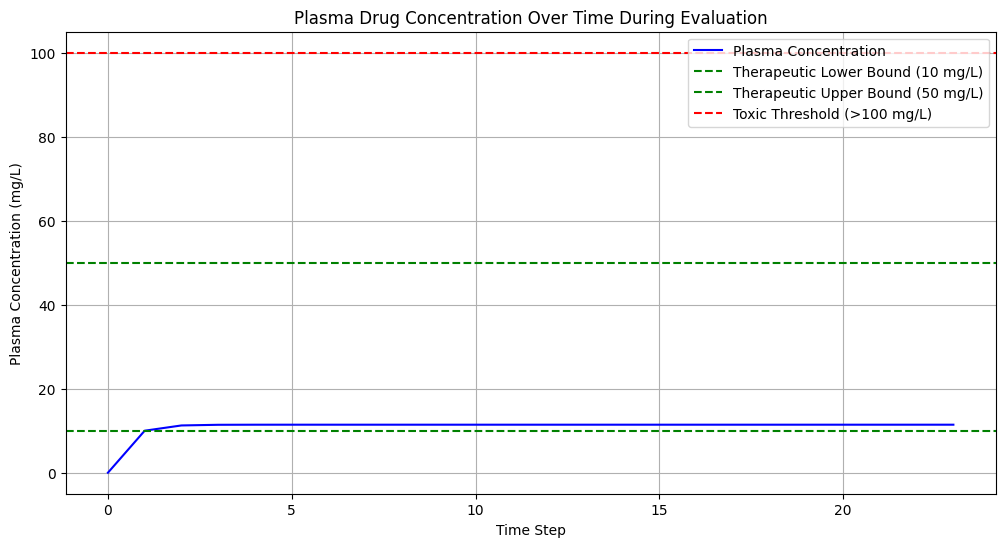

In [9]:
# Import necessary libraries
import gymnasium as gym  # Updated to gymnasium
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

import gymnasium as gym  # Updated to gymnasium
import numpy as np

class IbuprofenEnv(gym.Env):  # Inherit from gymnasium.Env
    def __init__(self):
        super(IbuprofenEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(5)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32)
        self.therapeutic_range = (10, 50)
        self.half_life = 2.0
        self.clearance_rate = 0.693 / self.half_life
        self.time_step_hours = 6
        self.max_steps = 24
        self.current_step = 0
        self.plasma_concentration = 0.0
        self.np_random = None  # Random number generator for seeding

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.

        Args:
            seed (int, optional): Random seed for reproducibility.
            options (dict, optional): Additional reset options.

        Returns:
            tuple: Observation (state) and info dictionary.
        """
        # Seed the environment's random number generator
        self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.current_step = 0
        self.plasma_concentration = 0.0
        return np.array([self.plasma_concentration], dtype=np.float32), {}  # Return state and info dict

    def step(self, action):
        """
        Take an action (dose) and return the new state, reward, terminated, truncated, and info.

        Args:
            action (int): The action to take.

        Returns:
            tuple: New state, reward, terminated, truncated, and info dictionary.
        """
        dose_mg = action * 200
        absorbed = dose_mg / 10
        self.plasma_concentration += absorbed
        self.plasma_concentration *= np.exp(-self.clearance_rate * self.time_step_hours)

        # Compute reward
        if self.therapeutic_range[0] <= self.plasma_concentration <= self.therapeutic_range[1]:
            reward = 10
        elif self.plasma_concentration > 100:
            reward = -20
        elif self.plasma_concentration < self.therapeutic_range[0]:
            reward = -5
        else:
            reward = -10

        # Increment step count
        self.current_step += 1

        # Determine termination and truncation
        terminated = False  # No explicit terminal states in this environment
        truncated = self.current_step >= self.max_steps  # Episode ends after max steps

        return np.array([self.plasma_concentration], dtype=np.float32), reward, terminated, truncated, {}


# Initialize the environment
env = IbuprofenEnv()

# Check if the environment is compatible with SB3
check_env(env, warn=True)

# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Evaluate the trained model
state_trajectory = []
state, _ = env.reset()  # Gymnasium reset returns a tuple (state, info)
done = False

while not done:
    state_trajectory.append(state[0])
    action, _ = model.predict(state, deterministic=True)  # Use the trained policy to predict actions
    state, reward, terminated, truncated, _ = env.step(action)  # Unpack all five returned values
    done = terminated or truncated  # Combine terminated and truncated to determine when to stop

# Plot the plasma concentration over time
plt.figure(figsize=(12, 6))
plt.plot(range(len(state_trajectory)), state_trajectory, label='Plasma Concentration', color='b')
plt.axhline(y=10, color='g', linestyle='--', label='Therapeutic Lower Bound (10 mg/L)')
plt.axhline(y=50, color='g', linestyle='--', label='Therapeutic Upper Bound (50 mg/L)')
plt.axhline(y=100, color='r', linestyle='--', label='Toxic Threshold (>100 mg/L)')
plt.xlabel('Time Step')
plt.ylabel('Plasma Concentration (mg/L)')
plt.title('Plasma Drug Concentration Over Time During Evaluation')
plt.legend()
plt.grid()
plt.show()
